<a href="https://colab.research.google.com/github/romenlaw/RL-playground/blob/main/rl_playground4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPRL book chapter 8 - Introduction to Value-Based Deep Reinforcement Learning

# Preparation

In [4]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gym
import io
import os
import gc

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

LEAVE_PRINT_EVERY_N_SECS = 60
ERASE_LINE = '\x1b[2K'
EPS = 1e-6
BEEP = lambda: os.system("printf '\a'")
RESULTS_DIR = os.path.join('..', 'results')
SEEDS = (12, 34, 56, 78, 90)

%matplotlib inline

In [5]:
plt.style.use('fivethirtyeight')
params = {
  'figure.figsize': (15, 8),
  'font.size': 24,
  'legend.fontsize': 20,
  'axes.titlesize': 28,
  'axes.labelsize': 24,
  'xtick.labelsize': 20,
  'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
torch.cuda.is_available()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

# Utils

In [7]:
def get_make_env_fn(**kargs):
  def make_env_fn(env_name,
                  seed=None,
                  render=None,
                  record=False,
                  unwrapped=False,
                  monitor_mode=None, # record video
                  inner_wrappers=None,
                  outer_wrappers=None):
    # tmp_dir = tempfile.mkdtemp()
    env = None
    if render:
      try:
        env = gym.make(env_name, render=render)
      except:
        print(f"error: render={render}")
        pass
    if env is None: env = gym.make(env_name)
    if seed is not None: env.seed(seed)
    env = env.unwrapped if unwrapped else env
    if inner_wrappers:
      for wrapper in inner_wrappers:
        env = wrapper(env)

    env = gym.wrappers.RecordVideo(env, './video_'+monitor_mode
                                   ) if record else env
    # env = wrappers.Monitor(env, tmp_dir, force=True, # override temp file
    #                        mode=monitor_mode,
    #                        video_callable=lambda e_idx: record
    #                        ) if monitor_mode else env
    if outer_wrappers:
      for wrapper in outer_wrappers:
        env = wrapper(env)
    return env
  return make_env_fn, kargs

In [8]:
make_env_fn, make_env_kargs = get_make_env_fn(env_name="CartPole-v1")

In [9]:
def get_videos_html(env_videos, title, max_n_videos=5):
  '''
  env_videos - list of videos
  title - heading/title of the html heading
  max_n_videos - max number of videos; can be larger or smaller tha len of the env_videos list
  '''
  print(env_videos)
  videos = np.array(env_videos)
  if len(videos) ==0:
    return
  n_videos = max(1, min(max_n_videos, len(videos)))
  idxs = np.linspace(0, len(videos)-1, n_videos).astype(int) if n_videos>1 else [-1,]
  videos = videos[idxs, ...]

  strm = f'<h2>{title}</h2>'
  for video_path, meta_path in videos:
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    with open(meta_path) as data_file:
      meta = json.load(data_file)

    html_tag=f"""
    <h3>Episode {meta['episode_id']}</h3>
    <video width="960" height="540" controls>
      <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
    </video>
    """
    strm += html_tag
  return strm


In [10]:
class DiscountedCartPole(gym.Wrapper):
  def __init__(self, env):
    gym.Wrapper.__init__(self, env)

  def reset(self, **kwargs):
    return self.env.reset(**kwargs)

  def step(self, a):
    # step returns observation, reward, terminated, truncated, info
    o, r, d, _ = self.env.step(a)
    (x, x_dot, theta, theta_dot) = o
    pole_fell = x < -self.env.unwrapped.x_threshold \
      or x > self.env.unwrapped.x_threshold \
      or theta < -self.env.unwrapped.theta_threshold_radians \
      or theta > self.env.unwrapped.theta_threshold_radians
    r = -1 if pole_fell else 0
    return o, r, d, _

# NFQ
Neural Fitted Q Iteration (NFQ), one of the 1st neuro-net algo for reinforcment learning. It approximates action-value function - estimated as Q(s,a; θ).

The architecture we use for cart pole is State-in-values-out:
* input = state variables s: cart position, velocity, pole angle, velocity at tip
* output = vector of values Q(s): one for each action

In [11]:
# fully connected Q-function (state-in-values-out)
class FCQ(nn.Module):
  def __init__(self, input_dim, output_dim, hidden_dims=(32,32), activation_fc=F.relu):
    super(FCQ, self).__init__()
    self.activation_fc = activation_fc

    self.input_layer = nn.Linear(input_dim, hidden_dims[0])
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    """
    state: is a list of state variables, cart position, velocity, etc.
    """
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))
    x = self.output_layer(x)
    return x

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, rewards, new_states, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, rewards, new_states, is_terminals


## selecting an exploration strategy

Any techniques from chapter 4 for exploration-exploitation tradeoff will be fine. To keep it simple, we use an epsilon-greedy strategy on our NFQ implementation.

But we are trining an off-policy learning algo, i.e. there are two policies:
* a policy that generates behaviour, which in this case is an ϵ-greedy policy
* a policy that we are learning about, which is the greedy (an ultimately optimal) policy.

In [12]:
class GreedyStrategy():
  def __init__(self):
    self.exploratory_action_taken = False

  def select_action(self, model, state):
    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()
      return np.argmax(q_values)

In [13]:
class EGreedyStrategy():
  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon
    self.exploratory_action_taken = None

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()

    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

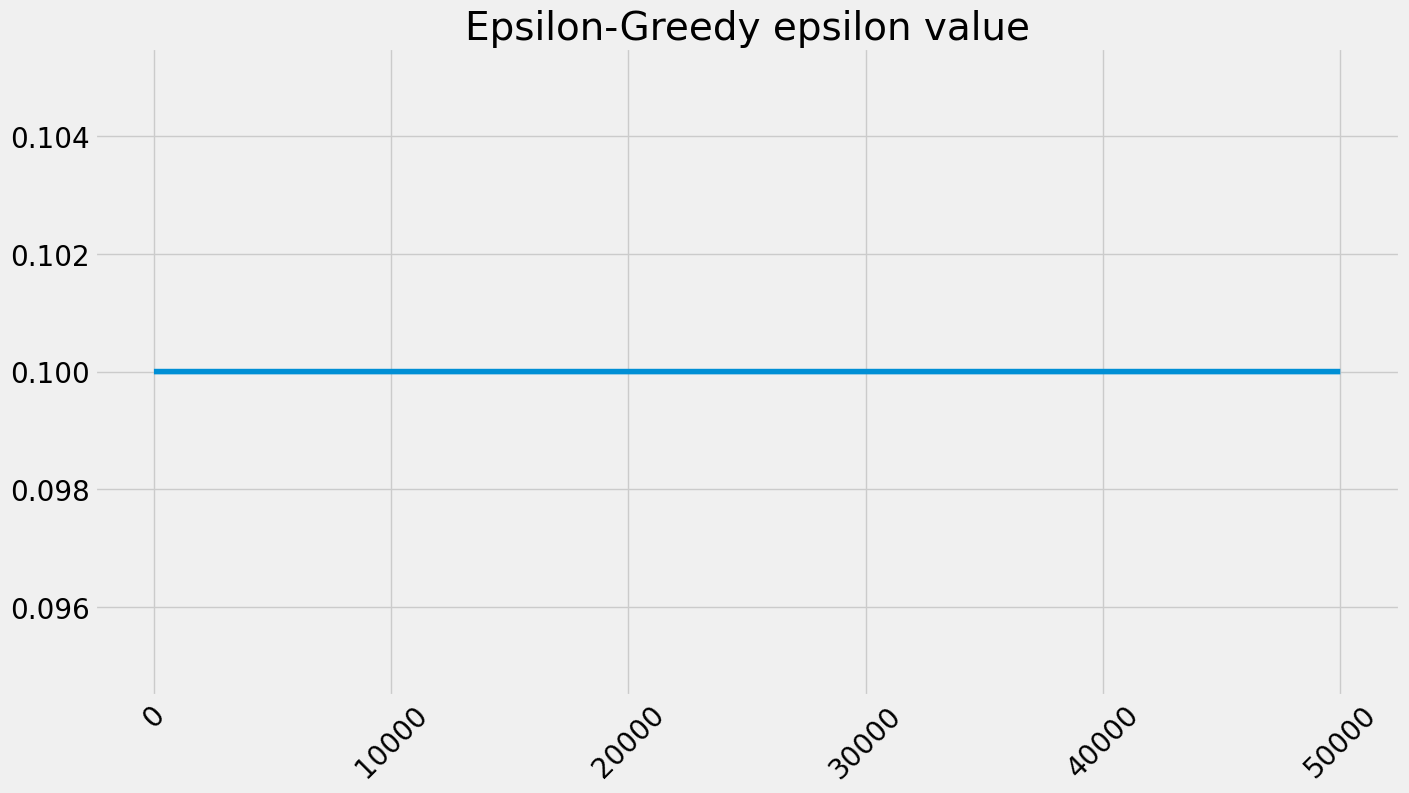

In [14]:
s = EGreedyStrategy()
plt.plot([s.epsilon for _ in range(50000)])
plt.title('Epsilon-Greedy epsilon value')
plt.xticks(rotation=45)
plt.show()

In [16]:
class EGreedyLinearStrategy():
  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.t = 0 # timestep
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.min_epsilon = min_epsilon
    self.decay_steps = decay_steps
    self.exploratory_action_taken = None

  def _epsilon_update(self):
    epsilon = 1 - self.t / self.decay_steps
    epsilon = (self.init_epsilon - self.min_epsilon) * epsilon + self.min_epsilon
    epsilon = np.clip(epsilon, self.min_epsilon, self.init_epsilon)
    self.t += 1
    return epsilon

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()

    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self.epsilon = self._epsilon_update()
    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

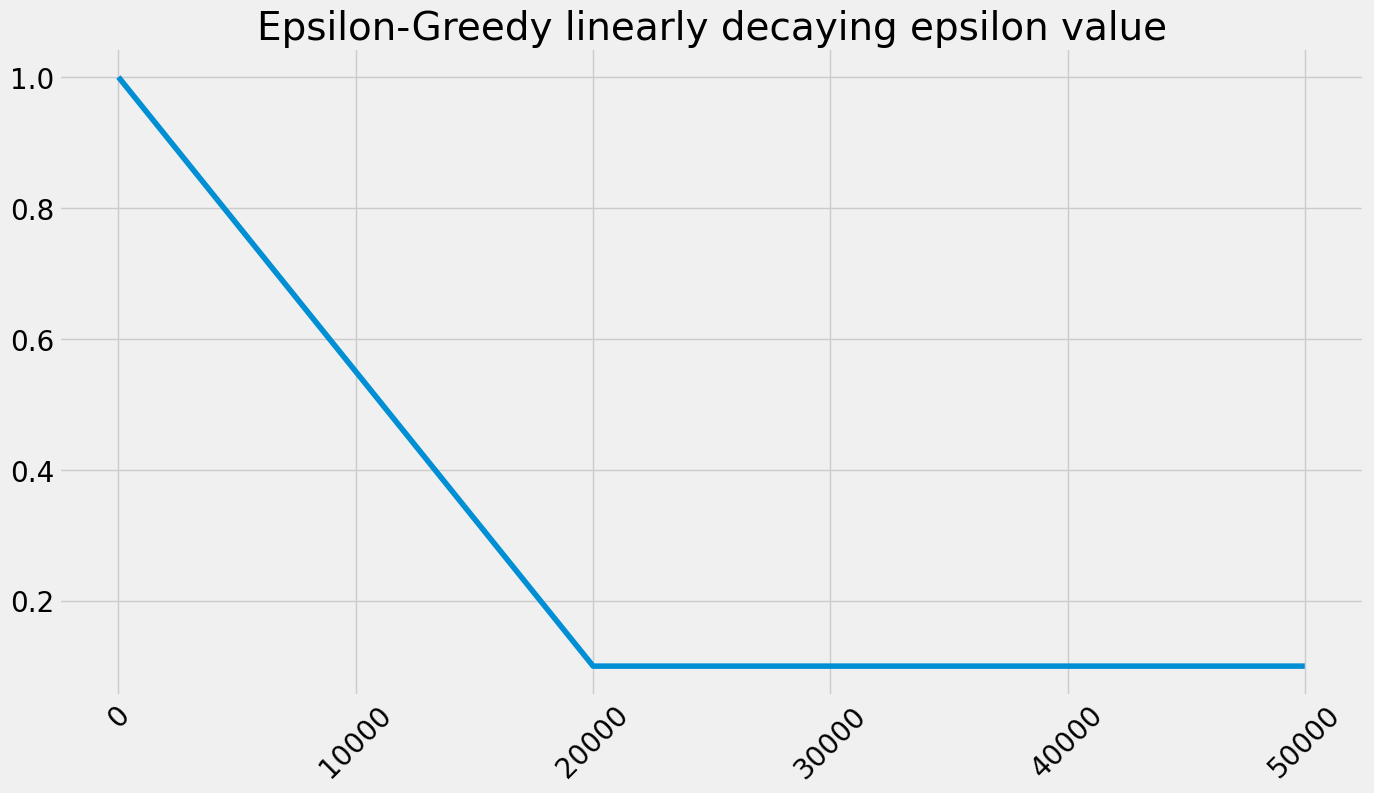

In [17]:
s = EGreedyLinearStrategy()
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy linearly decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [18]:
class EGreedyExpStrategy():
  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0
    self.exploratory_action_taken = None

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1
    return self.epsilon

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    with torch.no_grad():
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    self._epsilon_update()
    self.exploratory_action_taken = action != np.argmax(q_values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


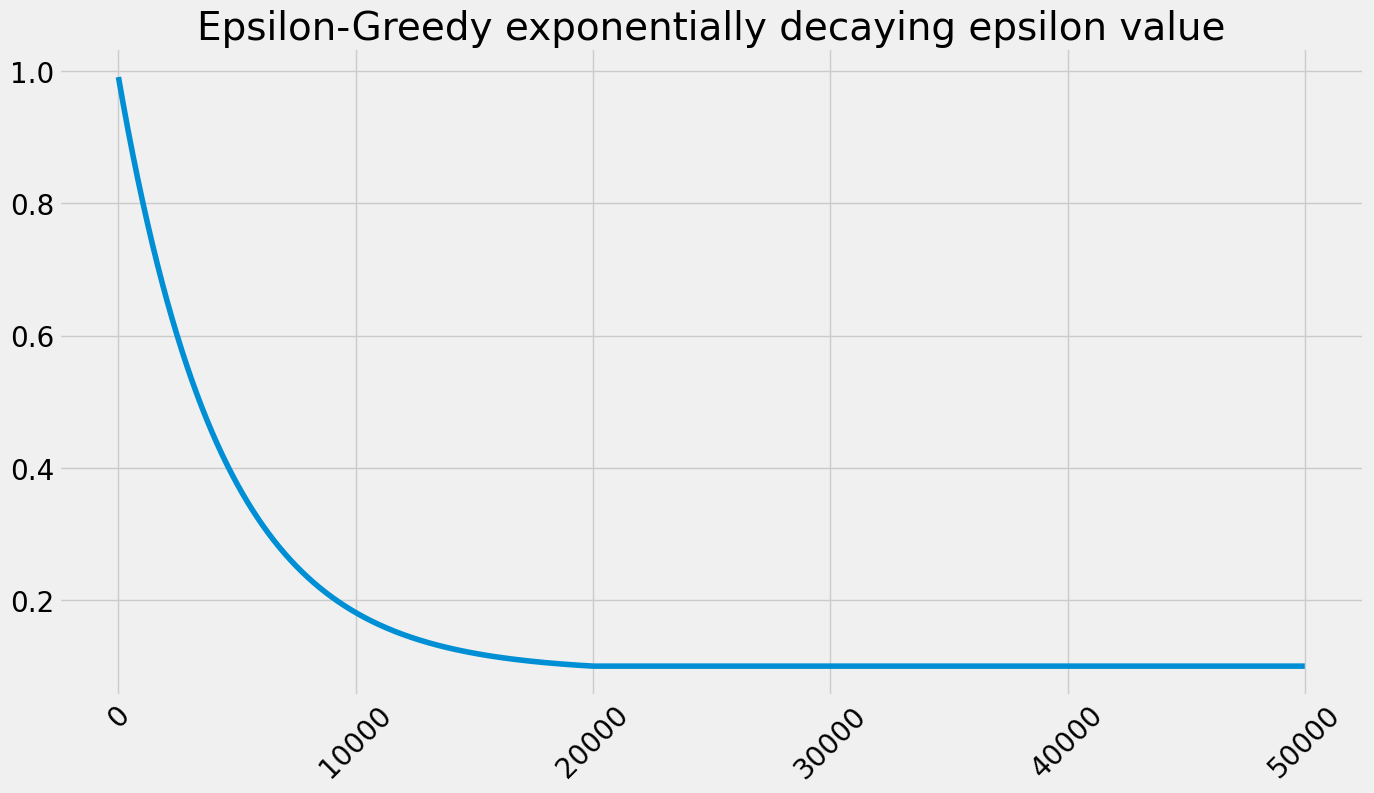

In [19]:
s = EGreedyExpStrategy()
plt.plot([s._epsilon_update() for _ in range(50000)])
plt.title('Epsilon-Greedy exponentially decaying epsilon value')
plt.xticks(rotation=45)
plt.show()

In [20]:
class SoftMaxStrategy():
  def __init__(self, init_temp=1.0, min_temp=0.3, exploration_ratio=0.8, max_steps=25000):
    self.t = 0
    self.init_temp = init_temp
    self.exploration_ratio = exploration_ratio
    self.min_temp = min_temp
    self.max_steps = max_steps
    self.exploratory_action_taken = None

  def _update_temp(self):
    temp = 1 - self.t / (self.max_steps * self.exploration_ratio)
    temp = (self.init_temp - self.min_temp) * temp + self.min_temp
    temp = np.clip(temp, self.min_temp, self.init_temp)
    self.t += 1
    return temp

  def select_action(self, model, state):
    self.exploratory_action_taken = False
    temp = self._update_temp()

    with torch.no_grad():
      q_values = model(state).cpu().detach().data.numpy().squeeze()
      scaled_qs = q_values / temp
      norm_qs = scaled_qs - scaled_qs.max()
      e = np.exp(norm_qs)
      probs = e / np.sum(e)
      assert np.isClose(probs.sum(), 1.0)

    action = np.random.coice(np.arange(len(probs)), size=1, p=probs)[0]
    self.exploratory_action_taken = action != np.argmax(q_values)
    return action

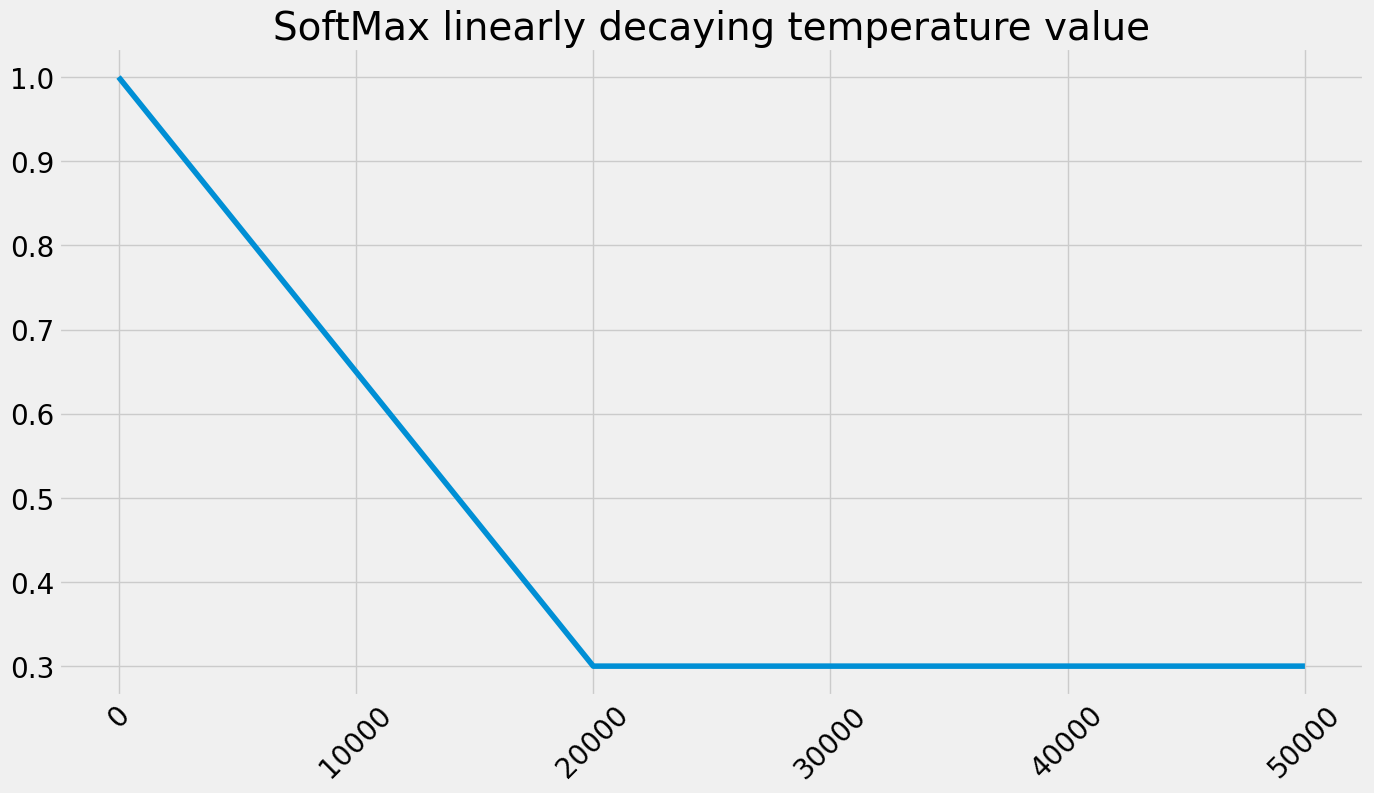

In [21]:
s = SoftMaxStrategy()
plt.plot([s._update_temp() for _ in range(50000)])
plt.title('SoftMax linearly decaying temperature value')
plt.xticks(rotation=45)
plt.show()

## selecting what to optimise
An ideal objective in value-based DRL would be to minimise the loss w.r.t. the optimal action-value function q⋆.
$$L_i(θ_i)=\mathbb{E}_{s,a}\left[\left(q_*(s,a)-Q(s,a;\theta_i)\right)^2\right]
$$
Because we'd like to have an estimate of q*, Q, that tracks exactly that optimal function, if we had a solid estimate of q*, we then could use a greedy action w.r.t. these estimates to get near optimal behaviour.

Refesh the definition of optimal action=value function q⋆:
$$q_*(s,a)=\max_{π}\mathbb{E}_π\left[G_t|S_t=s, A_t=a\right], ∀s∈S,∀a\in A(s)
$$
The optimal action-value function q⋆ is the poicy π that gives the maximum expected return from each and every action in each and every state.

For our NFQ implementation, we start with a randomly initialised q function (and implicit policy). Then evaluate the policy by sampling actions from it, same as chapter 5. Then iprove it with an exploration strategy such as epsilon-greedy, like in chapter 4. Finally, keep iterating until we reach the desired peformance, as in chapters 6 and 7.

## selecting targets for policy evaluation
Out of MC, TD, N-step, Lambda targets, any one would do. For simplicity we choose TD target.

TD targets can be either
* on-policy: Sarsa target for on-policy bootstrapping - use the action-value function of the action the agent will take at the landing state; the target would be approximatin gthe behavioural policy, i.e. the policy-generating behaviour and the policy being learned would be the same.
* off-policy: Q-learning for off-policy bootstrapping - use the value of the best action at the next state; we always approximate the greedy poicy, even if the policy-generating behaviour is not totally greedy.
$$
y_{i}^{Sarsa}=R_{t+1}+γQ(S_{t+1},A_{t+1};θ_i)
$$
$$
y_{i}^{Q-learning}=R_{t+1}+γ\max_{a}Q(S_{t+1},a;θ_i)
$$

In our NFQ implemenation, we will use the off-policy TD target. Substituting $y_i^{Q-learning}$ into the above loss function $L_i$:
$$L_i(θ_i)=\mathbb{E}_{s,a,r,s'}\left[\left(r+γ\max_{a'}Q(s',a';θ_i)-Q(s,a;\theta_i)\right)^2\right]
$$

Notice that when differentiating througth this equation, the gradiet does not involve the target y, the gradient must only go through the predicted value Q:
$$
∇_{θ_i} L_i(θ_i)=\mathbb{E}_{s,a,r,s'}\left[\left(r+γ\max_{a'}Q(s',a';θ_i)-Q(s,a;\theta_i)\right)\nabla_{θ_i}Q(s,a;\theta_i)\right]
$$

## select loss function
We use MSE (or L2 loss) - in the code below optimize_model().

The loss function measures the distance between predicted values (of the Q-function, coming from the neuro-net) and 'true values' (TD targets, which depend on a prediction also coming from the network, the value of next state). So there is a circular dependency of the action-value function.

In [15]:
class NFQ():
  def __init__(self,
               value_model_fn,
               value_optimizer_fn,
               value_optimizer_lr,
               training_strategy_fn,
               evaluation_strategy_fn,
               batch_size,
               epochs):
    self.value_model_fn = value_model_fn
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr
    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn
    self.batch_size = batch_size
    self.epochs = epochs


  def optimize_model(self, experiences):
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    # we get the values of Q-function at s_prime (next_state).
    # 'next_states' is plural because it's a batch of 'next_state'.
    # detach() here becasue we don't propagate values through this, this keeps
    # the predicted vlaue a constant since we only use it to calculate targets.
    # q_sa = self.online_model(next_states).detach()
    max_a_q_sp = self.online_model(next_states).detach().max(1)[0].unsqueeze(1)
    # *(1-is_terminals) to ensure terminal states are grounded to zero.
    target_q_s = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

    # get the current estimate of Q(s,a).
    q_sa = self.online_model(states).gather(1, actions)

    td_errors = target_q_s - q_sa
    value_loss = td_errors.pow(2).mul(0.5).mean()
    # back prop
    self.value_optimizer.zero_grad()
    value_loss.backward()
    self.value_optimizer.step()

  def interaction_step(self, state, env):
    action = self.training_strategy.select_action(self.online_model, state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))

    self.experiences.append(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
    return new_state, is_terminal

  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    print(f'checkpoint_dir: {self.checkpoint_dir}')
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.online_model = self.value_model_fn(nS, nA)
    self.value_optimizer = self.value_optimizer_fn(self.online_model,
                                                   self.value_optimizer_lr)

    self.training_strategy = training_strategy_fn()
    self.evaluation_strategy = evaluation_strategy_fn()
    self.experiences = []

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count(): # starting from 0
        state, is_terminal = self.interaction_step(state, env)
        # self.experiences is appended by self.interaction_step()

        if len(self.experiences) >= self.batch_size:
          experiences = np.array(self.experiences, dtype=object)
          batches = [np.vstack(sars) for sars in experiences.T]
          experiences = self.online_model.load(batches)
          for _ in range(self.epochs):
            self.optimize_model(experiences)
          self.experiences.clear()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_model, env)
      self.save_checkpoint(episode-1, self.online_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix


    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        #subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))

## select an Optimization method
Gradient descent is a stable optimisation method given the following assumptions:
1. IID assumption - Idependent and Identically Distributed.
2. targets are stationary.

However, in RL, the above assumptions don't hold. In practice, both Adam (Adaptive movement estimation) and RMSprop are sensible choices for value-based DRL methods.

NFQ has 3 main steps:
1. collect E experiences: (s, a, r, s', d) tuples. We use 1024 samples. This is batch_size in code
2. calculate the off-policy TD targets: $r+γ\max_{a'}Q(s',a';θ)$
3. fit the action-value function Q(s,a;θ): using MSE and RMSprop

The algo repeats steps 2 and 3 $K$ number of times before going back to step 1. That's what makes it 'fitted'; the nested loop. We will use 40 fitting steps $K$. This is epoch in code.

# Train NFQ

In [168]:
nfq_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512, 128))
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 5e-4

  training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5) # or 0.05
  evaluation_strategy_fn = lambda: GreedyStrategy()

  batch_size = 1024
  epochs = 40

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = NFQ(value_model_fn,
              value_optimizer_fn,
              value_optimizer_lr,
              training_strategy_fn,
              evaluation_strategy_fn,
              batch_size,
              epochs)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  nfq_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

nfq_results = np.array(nfq_results)
_ = BEEP()


checkpoint_dir: /tmp/tmpi8kklq0i
el 00:00:00, ep 0000, ts 000017, ar 10 017.0±000.0, 100 017.0±000.0, ex 100 0.4±0.0, ev 009.0±000.0


KeyboardInterrupt: 

Above debug messages:
* el = elapsed time
* ep = episode
* ts = total steps
* ar 10 = last 10 reward mean, std
* 100 = last 100 reward mean, std
* ex = last 100 exploration ratio mean, std
* ev = last 100 eval score mean, std

In [171]:
best_agent.demo_progression()

error: render=True
[('./video_prog/rl-video-episode-0.mp4', './video_prog/rl-video-episode-0.meta.json'), ('./video_prog/rl-video-episode-1.mp4', './video_prog/rl-video-episode-1.meta.json')]


In [172]:
best_agent.demo_last()

error: render=True
[('./video_last/rl-video-episode-0.mp4', './video_last/rl-video-episode-0.meta.json'), ('./video_last/rl-video-episode-1.mp4', './video_last/rl-video-episode-1.meta.json')]


In [201]:
nfq_max_t, nfq_max_r, nfq_max_s, nfq_max_sec, nfq_max_rt = np.max(nfq_results, axis=0).T
nfq_min_t, nfq_min_r, nfq_min_s, nfq_min_sec, nfq_min_rt = np.min(nfq_results, axis=0).T
nfq_mean_t, nfq_mean_r, nfq_mean_s, nfq_mean_sec, nfq_mean_rt = np.mean(nfq_results, axis=0).T
nfq_x = np.arange(len(nfq_mean_s))

In [203]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
not os.path.exists(nfq_root_dir) and os.makedirs(nfq_root_dir)

np.save(os.path.join(nfq_root_dir, 'x'), nfq_x)

np.save(os.path.join(nfq_root_dir, 'max_r'), nfq_max_r)
np.save(os.path.join(nfq_root_dir, 'min_r'), nfq_min_r)
np.save(os.path.join(nfq_root_dir, 'mean_r'), nfq_mean_r)

np.save(os.path.join(nfq_root_dir, 'max_s'), nfq_max_s)
np.save(os.path.join(nfq_root_dir, 'min_s'), nfq_min_s )
np.save(os.path.join(nfq_root_dir, 'mean_s'), nfq_mean_s)

np.save(os.path.join(nfq_root_dir, 'max_t'), nfq_max_t)
np.save(os.path.join(nfq_root_dir, 'min_t'), nfq_min_t)
np.save(os.path.join(nfq_root_dir, 'mean_t'), nfq_mean_t)

np.save(os.path.join(nfq_root_dir, 'max_sec'), nfq_max_sec)
np.save(os.path.join(nfq_root_dir, 'min_sec'), nfq_min_sec)
np.save(os.path.join(nfq_root_dir, 'mean_sec'), nfq_mean_sec)

np.save(os.path.join(nfq_root_dir, 'max_rt'), nfq_max_rt)
np.save(os.path.join(nfq_root_dir, 'min_rt'), nfq_min_rt)
np.save(os.path.join(nfq_root_dir, 'mean_rt'), nfq_mean_rt)

# Load from files

In [173]:
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_r.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_rt.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_s.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_sec.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_t.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_r.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_rt.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_s.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_sec.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_t.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_r.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_rt.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_s.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_sec.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/min_t.npy
!wget -nv https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/x.npy

2024-12-25 05:27:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_r.npy [80128/80128] -> "max_r.npy" [1]
2024-12-25 05:27:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_rt.npy [80128/80128] -> "max_rt.npy" [1]
2024-12-25 05:27:30 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_s.npy [80128/80128] -> "max_s.npy" [1]
2024-12-25 05:27:31 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_sec.npy [80128/80128] -> "max_sec.npy" [1]
2024-12-25 05:27:31 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/max_t.npy [80128/80128] -> "max_t.npy" [1]
2024-12-25 05:27:31 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_r.npy [80128/80128] -> "mean_r.npy" [1]
2024-12-25 05:27:32 URL:https://raw.githubusercontent.com/romenlaw/RL-playground/main/save_file/mean_rt.npy [80128/80128] -> "mean_rt.npy" [1]
2024-12-25 05:2

In [26]:
nfq_x = np.load('x.npy')

nfq_max_r = np.load('max_r.npy')
nfq_min_r = np.load('min_r.npy')
nfq_mean_r = np.load('mean_r.npy')

nfq_max_s = np.load('max_s.npy')
nfq_min_s = np.load('min_s.npy')
nfq_mean_s = np.load('mean_s.npy')

nfq_max_t = np.load('max_t.npy')
nfq_min_t = np.load('min_t.npy')
nfq_mean_t = np.load('mean_t.npy')

nfq_max_sec = np.load('max_sec.npy')
nfq_min_sec = np.load('min_sec.npy')
nfq_mean_sec = np.load('mean_sec.npy')

nfq_max_rt = np.load('max_rt.npy')
nfq_min_rt = np.load('min_rt.npy')
nfq_mean_rt = np.load('mean_rt.npy')

# Plotting NFQ

## Training Moving Average Reward
Notice that the training reward never reaches the max of 500-reward per episode. The reason is we are using an epsilon of 0.5. Having such high exploration rate helps with finding more accurate value functions but it shows worse performance during training.

Text(0.5, 0, 'Episodes')

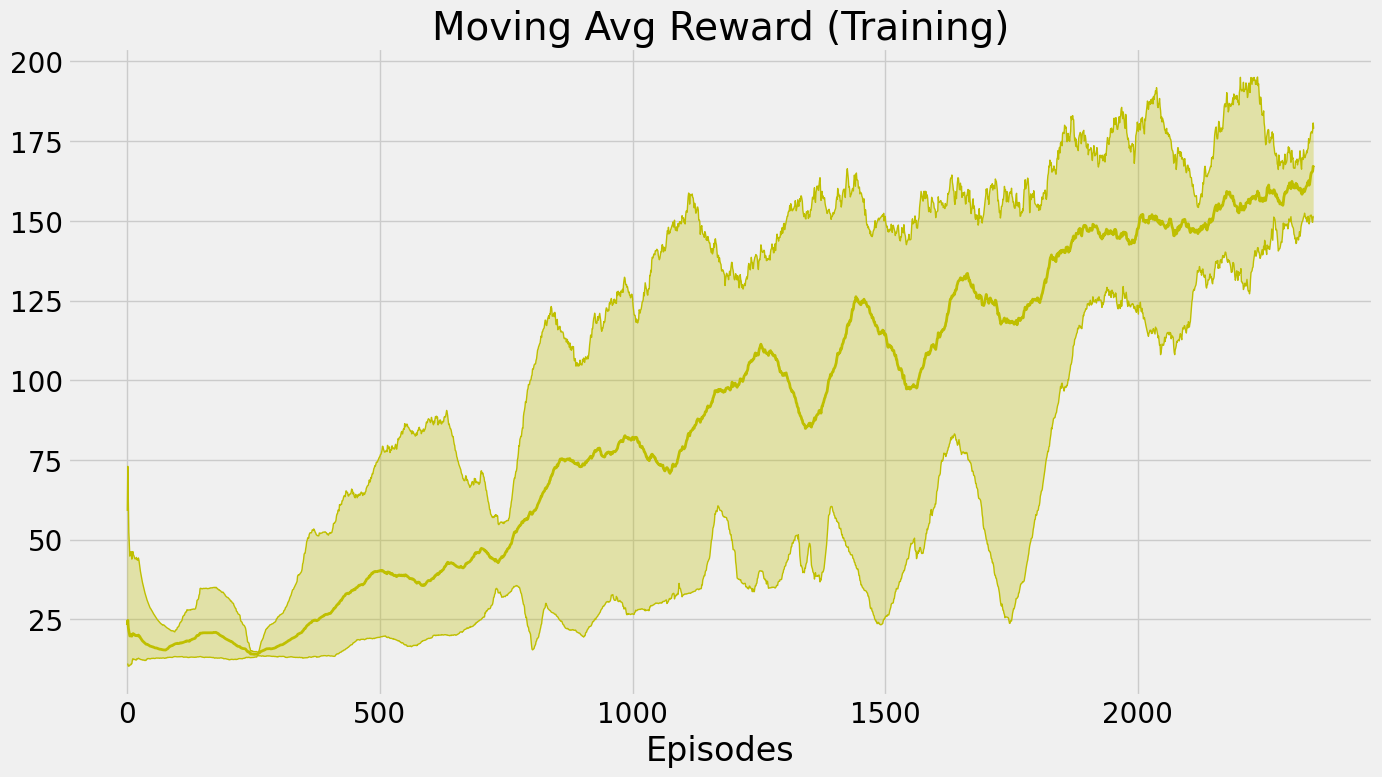

In [43]:
plt.plot(nfq_max_r, 'y', linewidth=1)
plt.plot(nfq_min_r, 'y', linewidth=1)
plt.plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)
plt.title('Moving Avg Reward (Training)')
plt.xlabel('Episodes')

## Evaluation Moving Average Reward
The evaluation steps ar ethe best performance we can obtain from the agent.

Text(0.5, 0, 'Episodes')

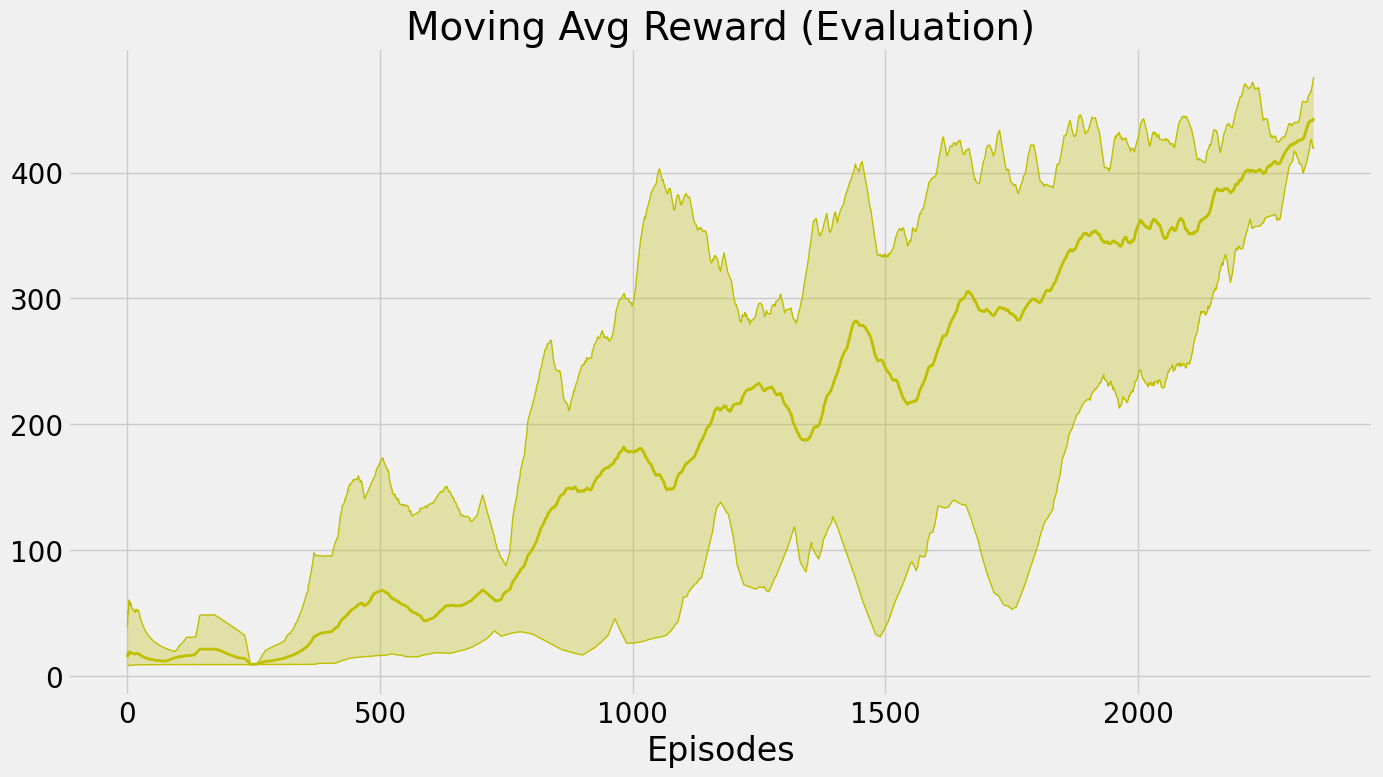

In [44]:
plt.plot(nfq_max_s, 'y', linewidth=1)
plt.plot(nfq_min_s, 'y', linewidth=1)
plt.plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)
plt.title('Moving Avg Reward (Evaluation)')
plt.xlabel('Episodes')

## Total Steps
The main issue with NFQ is that it takes too many steps to get decent performance. In other words, in terms of sample efficiency, NFQ does poorly. It needs many samples before it gets decent results. It doesn't get the most out of each sample.

Text(0.5, 0, 'Episodes')

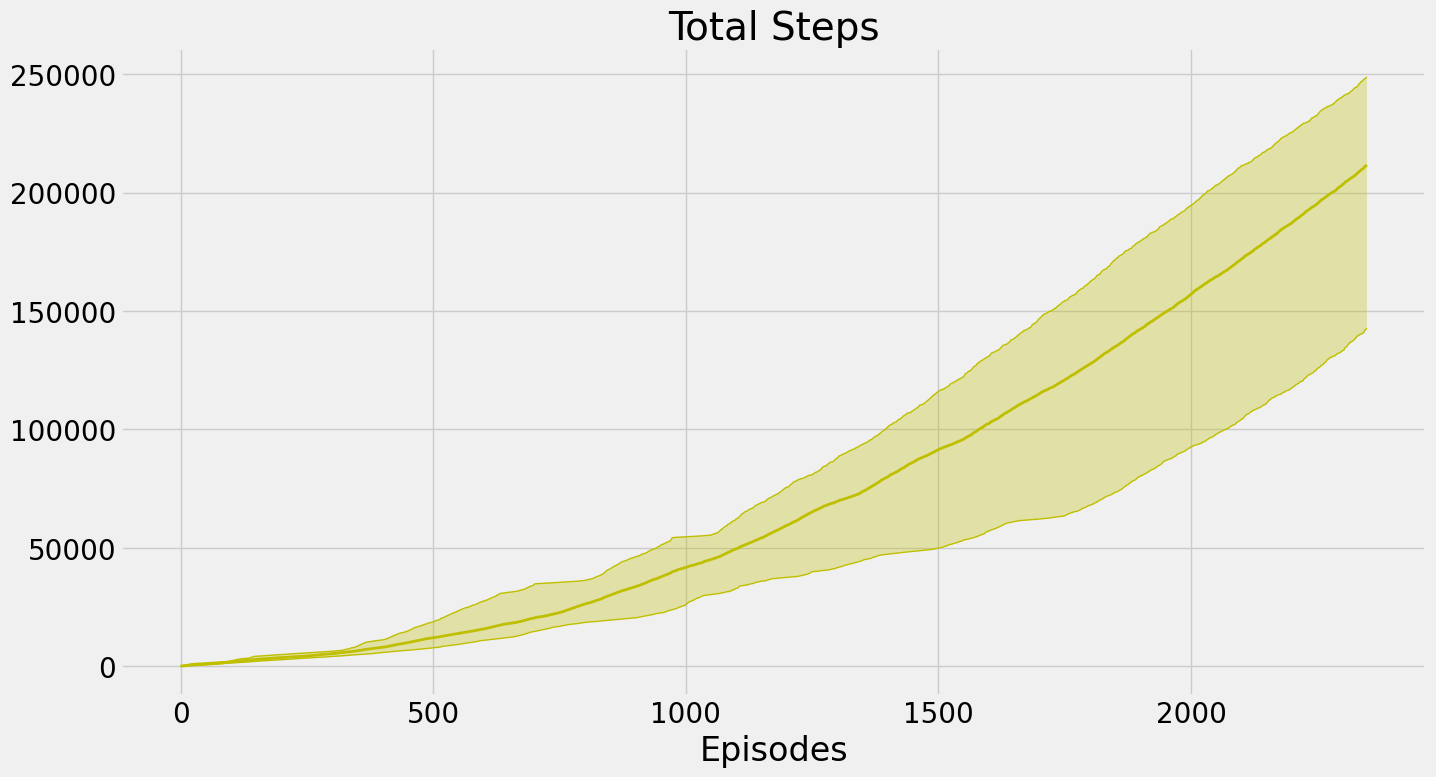

In [45]:
plt.plot(nfq_max_t, 'y', linewidth=1)
plt.plot(nfq_min_t, 'y', linewidth=1)
plt.plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)
plt.title('Total Steps')
plt.xlabel('Episodes')

## Training Time
Training time is the time excluding evaluation steps, statistics, etc.

Text(0.5, 0, 'Episodes')

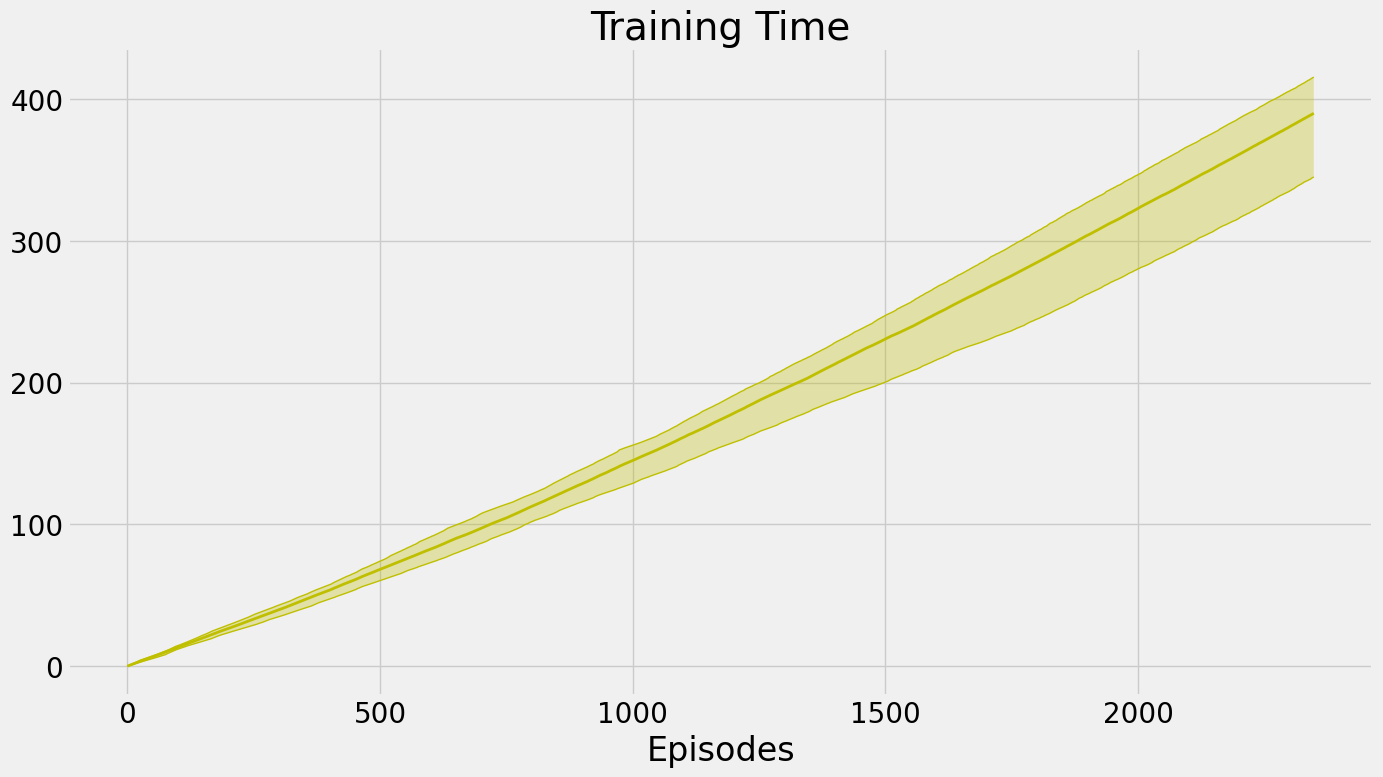

In [46]:
plt.plot(nfq_max_sec, 'y', linewidth=1)
plt.plot(nfq_min_sec, 'y', linewidth=1)
plt.plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)
plt.title('Training Time')
plt.xlabel('Episodes')

## Wall-clock Time
it shows how long it takes to run from beginning to end.

Text(0.5, 0, 'Episodes')

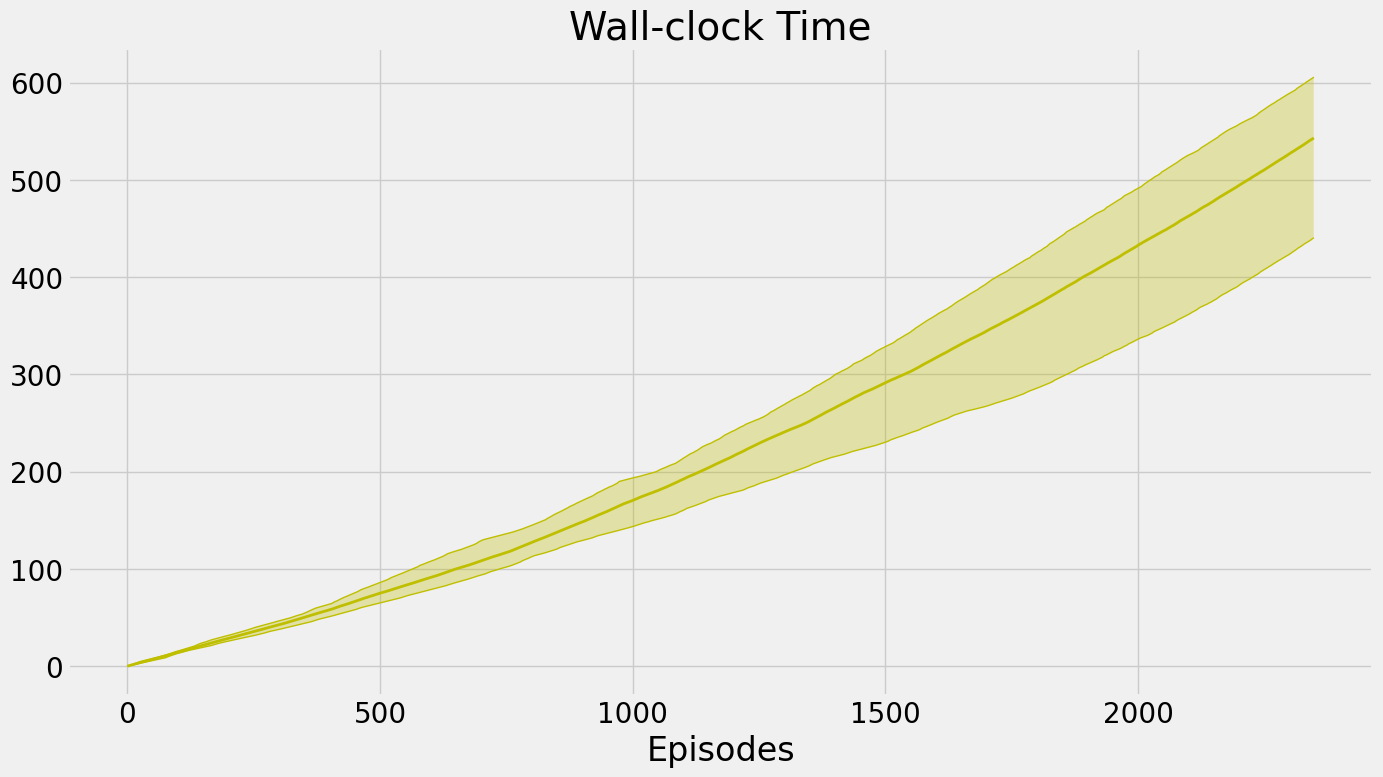

In [48]:
plt.plot(nfq_max_rt, 'y', linewidth=1)
plt.plot(nfq_min_rt, 'y', linewidth=1)
plt.plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
plt.fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)
plt.title('Wall-clock Time')
plt.xlabel('Episodes')

# DQN
NFQ addresses the IID and non-stationary target issues using batch. By growing a batch, we have the opportunity of optimising several samples at the same time. The larger the batch, the more opportunity for collecting a diverse set of experience samples. This somewhat addresses IID assumption.

NFQ addresses the stationarity of target requirements by using the same mini-batch in multiple sequential optimization steps - for every E episodes, we 'fit' the neuro-net to the same mini-batch K times. That K in there allows the optimsation method to move toward the target more stably. This is similar to supervised learning, where we gather a dataset and train for multiple epochs.

Deep Q-Network (DQN) addresses the above issues better, by using target network. Our targets are fixed for as many steps as we fix our target network. A target network is an previous instance of the neural network that we freeze for a number of steps. The gradient update has now time to catch up to the target, which is much more stable when froze. This adds stability to the updates. It is common to freeze these
target network weights for 10 to 10,000 steps at a time - e.g. 10 for simple problems like cart pole, 10000 for ATARI games.



In [27]:
class ReplayBuffer():
  def __init__(self, max_size=10000, batch_size=64):
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0 # current index of buffer
    self.size = 0

  def store(self, sample):
    s, a, r, p, d = sample
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    self._idx += 1
    self._idx = self._idx % self.max_size

    self.size += 1
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    if batch_size == None:
      batch_size = self.batch_size

    # randomly choose 'batch_size' samples from buffer and put in experiences
    idxs = np.random.choice(self.size, batch_size, replace=False)
    experiences = np.vstack(self.ss_mem[idxs]), \
      np.vstack(self.as_mem[idxs]), \
      np.vstack(self.rs_mem[idxs]), \
      np.vstack(self.ps_mem[idxs]), \
      np.vstack(self.ds_mem[idxs])
    return experiences

  def __len__(self):
    return self.size


In [25]:
class DQN():
  def __init__(self,
               replay_buffer_fn,
               value_model_fn,
               value_optimizer_fn,
               value_optimizer_lr,
               training_strategy_fn,
               evaluation_strategy_fn,
               n_warmup_batches,
               update_target_every_steps):
    self.replay_buffer_fn = replay_buffer_fn
    self.value_model_fn = value_model_fn
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr
    self.training_strategy_fn = training_strategy_fn
    self.evaluation_strategy_fn = evaluation_strategy_fn
    self.n_warmup_batches = n_warmup_batches
    self.update_target_every_steps = update_target_every_steps

  # same as NFQ
  def optimize_model(self, experiences):
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)

    # we get the values of Q-function at s_prime (next_state).
    # 'next_states' is plural because it's a batch of 'next_state'.
    # detach() here becasue we don't propagate values through this, this keeps
    # the predicted vlaue a constant since we only use it to calculate targets.
    # q_sa = self.online_model(next_states).detach()
    max_a_q_sp = self.online_model(next_states).detach().max(1)[0].unsqueeze(1)
    # *(1-is_terminals) to ensure terminal states are grounded to zero.
    target_q_sa = rewards + self.gamma * max_a_q_sp * (1 - is_terminals)

    # get the current estimate of Q(s,a).
    q_sa = self.online_model(states).gather(1, actions)

    td_errors = target_q_sa - q_sa
    value_loss = td_errors.pow(2).mul(0.5).mean()
    # back prop
    self.value_optimizer.zero_grad()
    value_loss.backward()
    self.value_optimizer.step()

  def interaction_step(self, state, env):
    action = self.training_strategy.select_action(self.online_model, state)
    new_state, reward, is_terminal, info = env.step(action)
    # the cart-pole env has a wrapper that artificially teminates an episode after
    # some time steps. So we add extra code to check this.
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    is_failure = is_terminal and not is_truncated
    experience = (state, action, reward, new_state, float(is_failure))

    self.replay_buffer.store(experience) # the only difference from NFQ
    #self.experiences.append(experience)
    self.episode_reward[-1] += reward
    self.episode_timestep[-1] += 1
    self.episode_exploration[-1] += int(self.training_strategy.exploratory_action_taken)
    return new_state, is_terminal

  def update_network(self):
    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
      # torch's copy_ copies tensor to another
      target.data.copy_(online.data)


  def train(self, make_env_fn, make_env_kargs,
            seed, gamma,
            max_minutes, max_episodes, goal_mean_100_reward):
    training_start, last_debug_time = time.time(), float('-inf')

    self.checkpoint_dir = tempfile.mkdtemp()
    self.make_env_fn = make_env_fn
    self.make_env_kargs = make_env_kargs
    self.seed = seed
    self.gamma = gamma

    env = self.make_env_fn(**self.make_env_kargs, seed=self.seed)
    torch.manual_seed(self.seed); np.random.seed(self.seed); random.seed(self.seed)

    nS, nA = env.observation_space.shape[0], env.action_space.n
    self.episode_timestep = []
    self.episode_reward = []
    self.episode_seconds = []
    self.evaluation_scores = []
    self.episode_exploration = []

    self.target_model = self.value_model_fn(nS, nA) # extra to NFQ
    self.online_model = self.value_model_fn(nS, nA)
    self.update_network() # extra to NFQ
    self.value_optimizer = self.value_optimizer_fn(self.online_model,
                                                   self.value_optimizer_lr)

    self.replay_buffer = self.replay_buffer_fn() # extra to NFQ
    self.training_strategy = training_strategy_fn()
    self.evaluation_strategy = evaluation_strategy_fn()
    # self.experiences = []

    # the 5 dim are: total_step, mean_100_reward, mean_100_eval_score, training_time, wallclock_elapsed
    result = np.empty((max_episodes, 5))
    result[:] = np.nan
    training_time = 0
    for episode in range(1, max_episodes+1):
      episode_start = time.time()
      state, is_terminal = env.reset(), False
      self.episode_reward.append(0.0)
      self.episode_timestep.append(0.0)
      self.episode_exploration.append(0.0)

      for step in count(): # starting from 0
        state, is_terminal = self.interaction_step(state, env)
        # self.experiences is appended by self.interaction_step()

        min_samples = self.replay_buffer.batch_size * self.n_warmup_batches # extra to NFQ
        if len(self.replay_buffer) > min_samples:
          experiences = self.replay_buffer.sample()
          experiences = self.online_model.load(experiences)
          self.optimize_model(experiences)

        if np.sum(self.episode_timestep) % self.update_target_every_steps == 0:
          self.update_network()

        # if len(self.experiences) >= self.batch_size:
        #   experiences = np.array(self.experiences, dtype=object)
        #   batches = [np.vstack(sars) for sars in experiences.T]
        #   experiences = self.online_model.load(batches)
        #   for _ in range(self.epochs):
        #     self.optimize_model(experiences)
        #   self.experiences.clear()

        if is_terminal:
          gc.collect()
          break

      # stats
      episode_elapsed = time.time() - episode_start
      self.episode_seconds.append(episode_elapsed)
      training_time += episode_elapsed
      evaluation_score, _ = self.evaluate(self.online_model, env)
      self.save_checkpoint(episode-1, self.online_model)

      total_step = int(np.sum(self.episode_timestep))
      self.evaluation_scores.append(evaluation_score)

      mean_10_reward = np.mean(self.episode_reward[-10:])
      std_10_reward = np.std(self.episode_reward[-10:])

      mean_100_reward = np.mean(self.episode_reward[-100:])
      std_100_reward = np.std(self.episode_reward[-100:])

      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      std_100_eval_score = np.std(self.evaluation_scores[-100:])

      lst_100_exp_rat = np.array(self.episode_exploration[-100:]) \
        / np.array(self.episode_timestep[-100:])
      mean_100_exp_rat = np.mean(lst_100_exp_rat)
      std_100_exp_rat = np.std(lst_100_exp_rat)

      wallclock_elapsed = time.time() - training_start
      result[episode-1] = total_step, mean_100_reward, \
        mean_100_eval_score, training_time, wallclock_elapsed

      reached_debug_time = time.time() - last_debug_time >= LEAVE_PRINT_EVERY_N_SECS
      reached_max_minutes = wallclock_elapsed >= max_minutes * 60
      reached_max_episodes = episode >= max_episodes
      reached_goal_mean_reward = mean_100_eval_score >= goal_mean_100_reward
      training_is_over = reached_max_minutes or reached_max_episodes \
        or reached_goal_mean_reward

      elapsed_str = time.strftime("%H:%M:%S", time.gmtime(time.time()-training_start))
      debug_message = 'el {}, ep {:04}, ts {:06}, ' \
        'ar 10 {:05.1f}\u00B1{:05.1f}, ' \
        '100 {:05.1f}\u00B1{:05.1f}, ' \
        'ex 100 {:02.1f}\u00B1{:02.1f}, ' \
        'ev {:05.1f}\u00B1{:05.1f}'
      debug_message = debug_message.format(
        elapsed_str, episode-1, total_step, mean_10_reward, std_10_reward,
        mean_100_reward, std_100_reward, mean_100_exp_rat, std_100_exp_rat,
        mean_100_eval_score, std_100_eval_score
      )
      print(debug_message, end='\r', flush=True)
      if reached_debug_time or training_is_over:
        print(ERASE_LINE + debug_message, flush=True)
        last_debug_time = time.time()
      if training_is_over: # print crosses and ticks
        if reached_max_minutes: print(u'--> reached_max_minutes \u2715')
        if reached_max_episodes: print(u'--> reached_max_episodes \u2715')
        if reached_goal_mean_reward: print(u'--> reach_goal_mean_reward \u2713')
        break # break out of for step in count() loop

    final_eval_score, score_std = self.evaluate(self.online_model, env, n_episodes=100)
    wallclock_time = time.time() - training_start
    print('Training complete.')
    print(f'Final evaluation score {final_eval_score:.2f}\u00B1{score_std:.2f}'\
          ' in {training_time:.2f}s training time, {wallclock_time:.2f}s wallclock time.\n')
    env.close(); del env
    self.get_cleaned_checkpoints()
    return result, final_eval_score, training_time, wallclock_time

  # same as NFQ
  def evaluate(self, eval_policy_model, eval_env, n_episodes=1):
    rs = [] # rewards
    for _ in range(n_episodes):
      # state, is_terminal
      s, d = eval_env.reset(), False
      rs.append(0)
      for _ in count():
        a = self.evaluation_strategy.select_action(eval_policy_model, s)
        s, r, d, _ = eval_env.step(a)
        rs[-1] += r
        if d: break
    return np.mean(rs), np.std(rs)

  # same as NFQ
  def get_cleaned_checkpoints(self, n_checkpoints=5):
    try:
      return self.checkpoint_paths
    except AttributeError:
      self.checkpoint_paths={}

    paths = glob.glob(os.path.join(self.checkpoint_dir, '*.tar'))
    # the file name is like 'dir/model.0.tar', 'dir/model.1.tar', etc.
    paths_dic = {int(path.split('.')[-2]):path for path in paths}
    last_ep = max(paths_dic.keys())
    checkpoint_idxs = np.linspace(1, last_ep+1, n_checkpoints, endpoint=True, dtype=np.int16)-1

    for idx, path in paths_dic.items():
      if idx in checkpoint_idxs:
        self.checkpoint_paths[idx] = path
      else:
        os.unlink(path)

    return self.checkpoint_paths

  def demo_last(self, title='Fully-trained {} Agent', n_episodes=3, max_n_videos=3):
    vid_dir_suffix='last'
    video_dir =  './video_'+vid_dir_suffix


    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    last_ep = max(checkpoint_paths.keys())
    self.online_model.load_state_dict(torch.load(checkpoint_paths[last_ep]))

    self.evaluate(self.online_model, env, n_episodes=n_episodes)
    env.close()
    #########################
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def demo_progression(self, title='{} Agent progression', max_n_videos=5):
    vid_dir_suffix='prog'
    env = self.make_env_fn(**self.make_env_kargs, monitor_mode=vid_dir_suffix, render=True, record=True)

    checkpoint_paths = self.get_cleaned_checkpoints()
    for i in sorted(checkpoint_paths.keys()):
      self.online_model.load_state_dict(torch.load(checkpoint_paths[i]))
      self.evaluate(self.online_model, env, n_episodes=1)

    env.close()
    #########################
    video_dir =  './video_'+vid_dir_suffix
    video_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.mp4')]
    meta_files = [f'{video_dir}/{f}' for f in os.listdir(video_dir) if f.endswith('.meta.json')]
    vids = list(zip(video_files, meta_files))

    data = get_videos_html(env_videos=vids, #env.videos,
                        title=title.format(self.__class__.__name__),
                        #subtitle_eps=sorted(checkpoint_paths.keys()),
                        max_n_videos=max_n_videos)
    del env
    return HTML(data=data)

  def save_checkpoint(self, episode_idx, model):
    torch.save(model.state_dict(),
               os.path.join(self.checkpoint_dir, f'model.{episode_idx}.tar'))

# Train DQN

In [29]:
dqn_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
  environment_settings = {
      'env_name': 'CartPole-v1',
      'gamma': 1.00,
      'max_minutes': 20,
      'max_episodes': 10000,
      'goal_mean_100_reward': 475
  }

  value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512, 128))
  value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 5e-4

  training_strategy_fn = lambda: EGreedyExpStrategy(init_epsilon=1.0,
                                                    min_epsilon=0.3,
                                                    decay_steps=20000)
  evaluation_strategy_fn = lambda: GreedyStrategy()
  replay_buffer_fn = lambda: ReplayBuffer(max_size=50000, batch_size=64)
  n_warmup_batches = 5
  update_target_every_steps = 10

  env_name, gamma, max_minutes, max_episodes, goal_mean_100_reward = environment_settings.values()
  agent = DQN(replay_buffer_fn,
              value_model_fn,
              value_optimizer_fn,
              value_optimizer_lr,
              training_strategy_fn,
              evaluation_strategy_fn,
              n_warmup_batches,
              update_target_every_steps)

  make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
  result, final_eval_score, training_time, wallcock_time = agent.train(
      make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward
  )
  dqn_results.append(result)
  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent

dqn_results = np.array(dqn_results)
_ = BEEP()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

AssertionError: None (<class 'NoneType'>) invalid